In [62]:
import pandas as pd
import numpy as np
import yfinance as yf
import talib

df = pd.read_csv('E:/ryse/HFT/FutSF_TickKZ_CTP_Daily_202302/IC主力连续_20230201.csv', encoding='gbk')
f = df[['最新价','数量']].copy()
f.columns = ['price','volume']
f.loc[:,'time'] = pd.to_datetime(df['交易日'].astype(str) + ' ' + df['最后修改时间'])
f

,price,volume,time
0,6313.0,59,2023-02-01 09:29:00
1,6314.6,123,2023-02-01 09:30:00
2,6315.2,146,2023-02-01 09:30:00
3,6316.0,185,2023-02-01 09:30:01
4,6317.0,213,2023-02-01 09:30:01
...,...,...,...
25999,6361.4,39318,2023-02-01 14:59:59
26000,6361.0,39321,2023-02-01 14:59:59
26001,6361.0,39323,2023-02-01 15:00:00
26002,6361.0,39323,2023-02-01 15:27:20


In [63]:
def tick_to_minute(df, freq="min"):
    """
    将Tick数据转换为分钟级OHLC数据
    :param tick_df: DataFrame, 需包含时间戳索引和price/volume列
    :param freq: 重采样频率（默认为1分钟）
    :return: 分钟级DataFrame
    """
    df = df.copy()
    df['datetime'] = pd.to_datetime(df['time'])
    df.set_index('datetime', inplace=True)

    # 2. 使用 resample 将 tick 数据转换为分钟级数据
    # 计算价格的 OHLC 以及成交量的总和
    df_minute = df.resample(freq).agg({
        'price': ['first', 'max', 'min', 'last'],
        'volume': 'sum'
    })

    # 3. 整理列名称（可选）
    # df_minute.columns = ['_'.join(col).strip() for col in df_minute.columns.values]
    df_minute.columns = ['open', 'high', 'low', 'close', 'volume']
    df_minute = df_minute.reset_index()
    
    # 处理空值
    df_minute = df_minute.dropna()  # 或填充：minute_df.ffill()
    
    return df_minute

In [64]:
ff = tick_to_minute(f, freq="min")
# ff.columns = ['time','open', 'high', 'low', 'close', 'volume']
ff

,datetime,open,high,low,close,volume
0,2023-02-01 09:29:00,6313.0,6313.0,6313.0,6313.0,59
1,2023-02-01 09:30:00,6314.6,6324.6,6314.6,6317.8,69320
2,2023-02-01 09:31:00,6317.8,6323.2,6317.8,6321.4,117555
3,2023-02-01 09:32:00,6321.4,6325.2,6320.4,6323.6,156084
4,2023-02-01 09:33:00,6324.0,6332.2,6323.2,6330.0,197603
...,...,...,...,...,...,...
329,2023-02-01 14:58:00,6359.0,6359.0,6356.0,6357.8,4573394
330,2023-02-01 14:59:00,6357.6,6362.6,6356.8,6361.0,4619066
331,2023-02-01 15:00:00,6361.0,6361.0,6361.0,6361.0,39323
358,2023-02-01 15:27:00,6361.0,6361.0,6361.0,6361.0,39323


In [56]:
import pandas as pd
import numpy as np
import yfinance as yf

# ================== 参数设置 ==================
SYMBOL = 'AAPL'          # 交易标的
START_DATE = '2010-01-01'# 回测起始日期
END_DATE = '2020-12-31'  # 回测结束日期
INIT_CAPITAL = 100000    # 初始本金（美元）
RISK_PER_TRADE = 0.01    # 单笔交易风险比例（1%）

# 海龟参数
ENTRY_PERIOD = 20        # 唐奇安通道周期
EXIT_PERIOD = 10         # 退出通道周期
ATR_PERIOD = 14          # ATR计算周期
UNIT_RATIO = 0.5         # 每0.5倍ATR加仓一次
MAX_UNITS = 4            # 最大加仓次数

# ================== 数据准备 ==================
# 下载历史数据
# data = yf.download(SYMBOL, start=START_DATE, end=END_DATE)
data = ff[['Open', 'High', 'Low', 'Close']]

# 计算指标
data['high_entry'] = data['High'].rolling(ENTRY_PERIOD).max().shift(1)  # 入场通道上轨
data['low_exit'] = data['Low'].rolling(EXIT_PERIOD).min().shift(1)      # 离场通道下轨

# 计算ATR（平均真实波幅）
data['tr'] = np.maximum(data['High'] - data['Low'], 
                       np.maximum(abs(data['High'] - data['Close'].shift(1)),
                                  abs(data['Low'] - data['Close'].shift(1))))
data['atr'] = data['tr'].rolling(ATR_PERIOD).mean().shift(1)

# ================== 回测引擎 ==================
class Backtest:
    def __init__(self, data, initial_capital):
        self.data = data.dropna()
        self.capital = initial_capital
        self.position = 0    # 当前持仓数量
        self.units = 0       # 当前加仓次数
        self.trades = []     # 交易记录
        
    def run(self):
        for i, row in self.data.iterrows():
            # 当前价格
            price = row['Close']
            
            # 止损检查
            if self.position != 0:
                if (self.position > 0 and price < self.stop_loss) or \
                   (self.position < 0 and price > self.stop_loss):
                    self.close_position(price, '止损', i)
                    
            # 离场信号
            if self.position > 0 and price < row['low_exit']:
                self.close_position(price, '退出', i)
                
            # 入场信号（多头）
            if self.position == 0 and price > row['high_entry']:
                self.enter_position(price, row['atr'], i, direction=1)
                
            # 加仓逻辑（每0.5ATR波动加仓）
            elif self.position > 0 and price >= self.last_entry + self.unit_size:
                if self.units < MAX_UNITS:
                    self.add_position(price, i)
                    
        return pd.DataFrame(self.trades)
    
    def enter_position(self, price, atr, date, direction=1):
        # 计算头寸规模（基于1%风险）
        risk_amount = self.capital * RISK_PER_TRADE
        unit_size = risk_amount / (atr * 2)  # 2倍ATR止损
        units = int(unit_size / price)
        
        # 记录交易
        self.position = units * direction
        self.units = 1
        self.stop_loss = price - 2*atr if direction==1 else price + 2*atr
        self.unit_size = atr * UNIT_RATIO
        self.last_entry = price
        
        self.trades.append({
            'date': date,
            'type': '买入' if direction==1 else '卖出',
            'price': price,
            'units': units,
            'reason': '初始入场'
        })
    
    def add_position(self, price, date):
        add_units = int((self.capital * RISK_PER_TRADE) / (self.unit_size * price))
        self.position += add_units
        self.units += 1
        self.stop_loss = price - 2*self.unit_size  # 更新止损
        
        self.trades.append({
            'date': date,
            'type': '加仓',
            'price': price,
            'units': add_units,
            'reason': f'第{self.units}次加仓'
        })
    
    def close_position(self, price, reason, date):
        pnl = (price - self.last_entry) * abs(self.position)
        self.capital += pnl
        
        self.trades.append({
            'date': date,
            'type': '平仓',
            'price': price,
            'units': abs(self.position),
            'reason': reason,
            'profit': pnl
        })
        
        # 重置状态
        self.position = 0
        self.units = 0

# ================== 执行回测 ==================
bt = Backtest(data, INIT_CAPITAL)
results = bt.run()

# ================== 结果分析 ==================
print(f"最终资金: ${bt.capital:.2f}")
print(f"总收益率: {(bt.capital/INIT_CAPITAL-1)*100:.2f}%")

# 计算统计指标
if not results.empty:
    results['cum_profit'] = results['profit'].fillna(0).cumsum()
    max_drawdown = (results['cum_profit'].cummax() - results['cum_profit']).max()
    print(f"最大回撤: ${max_drawdown:.2f}")
    win_rate = len(results[results['profit'] > 0]) / len(results)
    print(f"胜率: {win_rate*100:.2f}%")

最终资金: $100000.00
总收益率: 0.00%


C:\Users\admin\AppData\Local\Temp\ipykernel_3116\349598768.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['high_entry'] = data['High'].rolling(ENTRY_PERIOD).max().shift(1)  # 入场通道上轨


KeyError: 'profit'

In [100]:
def turtle_backtest(df, channel_period=20, atr_period=20, add_threshold=0.5, stop_loss_mult=2):
    """
    海龟交易法则回测示例（含加仓逻辑，不含尾盘平仓逻辑）
    
    参数说明：
      df: 包含 datetime, open, high, low, close, volume 的 DataFrame（索引为 datetime）
      channel_period: 唐奇安通道周期（例如20日）
      atr_period: ATR 计算周期（例如20日）
      add_threshold: 加仓阈值，单位为 ATR（例如0.5 表示价格比最近入场价上涨/下跌 0.5×ATR时加仓）
      stop_loss_mult: 止损倍数（例如2 表示价格反向移动 2×ATR时止损）
      
    返回：
      result: 增加了信号、持仓、累计盈亏等信息的 DataFrame
      trade_log: 交易记录列表，每笔记录包含入场日期、方向、入场价格列表、出场日期、出场价格及盈亏
    """
    df = df.copy()
    
    # 计算 ATR（周期为 atr_period）
    df['ATR'] = talib.ATR(df['high'].values, df['low'].values, df['close'].values, timeperiod=atr_period)
    
    # 计算唐奇安通道（不包含当前K线，所以使用 shift(1)）
    df['Donchian_High'] = pd.Series(talib.MAX(df['high'].values, timeperiod=channel_period)).shift(1)
    df['Donchian_Low']  = pd.Series(talib.MIN(df['low'].values, timeperiod=channel_period)).shift(1)
    
    # 初始化各列
    df['Signal'] = 0           # 信号：1 表示开多或加多，-1 表示开空或加空，0 表示平仓
    df['Position'] = 0         # 持仓数量（正数为多头，负数为空头）
    df['Trade_Price'] = np.nan # 当天发生交易时记录价格
    df['Cum_PnL'] = 0.0        # 累计盈亏
    
    position = 0             # 当前持仓数量
    entry_prices = []        # 记录每个入场单的价格（用于加仓及止损）
    last_entry = None        # 最近一次入场价格
    cumulative_pnl = 0.0
    trade_log = []           # 用于记录每笔交易详情
    
    # 从 channel_period 行开始遍历（前面数据不足无法计算通道）
    for i in range(channel_period, len(df)):
        current_date = df.index[i]
        close = df.iloc[i]['close']
        atr = df.iloc[i]['ATR']
        don_high = df.iloc[i]['Donchian_High']
        don_low = df.iloc[i]['Donchian_Low']
        
        # 如果关键指标未计算出来，则跳过
        if pd.isna(atr) or pd.isna(don_high) or pd.isna(don_low):
            df.at[current_date, 'Position'] = position
            df.at[current_date, 'Cum_PnL'] = cumulative_pnl
            continue
        
        # 无仓位时，判断入场信号
        if position == 0:
            if close > don_high:
                # 突破上轨，开多仓
                position = 1
                entry_prices = [close]
                last_entry = close
                df.at[current_date, 'Signal'] = 1
                df.at[current_date, 'Trade_Price'] = close
                trade_log.append({
                    'Entry_Date': current_date,
                    'Direction': 'Long',
                    'Entry_Prices': entry_prices.copy()
                })
            elif close < don_low:
                # 突破下轨，开空仓
                position = -1
                entry_prices = [close]
                last_entry = close
                df.at[current_date, 'Signal'] = -1
                df.at[current_date, 'Trade_Price'] = close
                trade_log.append({
                    'Entry_Date': current_date,
                    'Direction': 'Short',
                    'Entry_Prices': entry_prices.copy()
                })
        else:
            # 持仓中：判断加仓和止损
            if position > 0:  # 多仓逻辑
                # 加仓条件：当前价格比最近入场价格上涨超过 add_threshold × ATR
                if close >= last_entry + add_threshold * atr:
                    position += 1
                    entry_prices.append(close)
                    last_entry = close  # 更新最新入场价格
                    df.at[current_date, 'Signal'] = 1  # 表示加仓
                    df.at[current_date, 'Trade_Price'] = close
                    trade_log[-1]['Entry_Prices'] = entry_prices.copy()
                # 止损条件：当前价格低于最近入场价格减去 stop_loss_mult × ATR
                elif close <= last_entry - stop_loss_mult * atr:
                    pnl = sum([close - price for price in entry_prices])
                    cumulative_pnl += pnl
                    df.at[current_date, 'Signal'] = 0  # 平仓信号
                    df.at[current_date, 'Trade_Price'] = close
                    trade_log[-1].update({
                        'Exit_Date': current_date,
                        'Exit_Price': close,
                        'PnL': pnl
                    })
                    position = 0
                    entry_prices = []
                    last_entry = None
            elif position < 0:  # 空仓逻辑
                # 加仓条件：当前价格比最近入场价格下跌超过 add_threshold × ATR
                if close <= last_entry - add_threshold * atr:
                    position -= 1
                    entry_prices.append(close)
                    last_entry = close
                    df.at[current_date, 'Signal'] = -1  # 表示加仓
                    df.at[current_date, 'Trade_Price'] = close
                    trade_log[-1]['Entry_Prices'] = entry_prices.copy()
                # 止损条件：当前价格高于最近入场价格加上 stop_loss_mult × ATR
                elif close >= last_entry + stop_loss_mult * atr:
                    pnl = sum([price - close for price in entry_prices])
                    cumulative_pnl += pnl
                    df.at[current_date, 'Signal'] = 0  # 平仓信号
                    df.at[current_date, 'Trade_Price'] = close
                    trade_log[-1].update({
                        'Exit_Date': current_date,
                        'Exit_Price': close,
                        'PnL': pnl
                    })
                    position = 0
                    entry_prices = []
                    last_entry = None
                    
        # 记录当天的持仓和累计盈亏
        df.at[current_date, 'Position'] = position
        df.at[current_date, 'Cum_PnL'] = cumulative_pnl
    
    # 最后，在 for 循环结束后，若仍有未平仓仓位，则使用最后一根K线的价格平仓
    if position != 0:
        final_date = df.index[-1]
        final_price = df.iloc[-1]['close']
        if position > 0:
            pnl = sum([final_price - price for price in entry_prices])
        else:
            pnl = sum([price - final_price for price in entry_prices])
        cumulative_pnl += pnl
        # 更新最后一笔交易记录，标记为最终平仓
        if trade_log:
            trade_log[-1].update({
                'Exit_Date': final_date,
                'Exit_Price': final_price,
                'PnL': pnl
            })
        df.at[final_date, 'Signal'] = 0
        df.at[final_date, 'Trade_Price'] = final_price
        df.at[final_date, 'Position'] = 0
        df.at[final_date, 'Cum_PnL'] = cumulative_pnl
        position = 0
        entry_prices = []
        last_entry = None
    
    return df, trade_log

In [107]:
result, trades = turtle_backtest(ff, channel_period=5, atr_period=5, add_threshold=0.5, stop_loss_mult=1)

# 输出最后几行回测结果
print(result[['open', 'high', 'low', 'close', 'ATR', 'Donchian_High', 'Donchian_Low', 'Signal', 'Position', 'Cum_PnL']].tail())

total_pnl = 0
# 输出交易记录
print("交易记录：")
for trade in trades:
    print(trade)
    total_pnl += trade.get('PnL', 0)
print(total_pnl)

       open    high     low   close       ATR  Donchian_High  Donchian_Low  \
329  6359.0  6359.0  6356.0  6357.8  2.451478            NaN           NaN   
330  6357.6  6362.6  6356.8  6361.0  3.121183            NaN           NaN   
331  6361.0  6361.0  6361.0  6361.0  2.496946            NaN           NaN   
358  6361.0  6361.0  6361.0  6361.0  1.997557            NaN           NaN   
363  6361.0  6361.0  6361.0  6361.0  1.598046            NaN           NaN   

     Signal  Position  Cum_PnL  
329       0        -3    101.0  
330       0        -3    101.0  
331       0        -3    101.0  
358       0        -3    101.0  
363       0         0     61.2  
交易记录：
{'Entry_Date': 5, 'Direction': 'Long', 'Entry_Prices': [6334.2, 6340.8, 6344.4, 6348.8, 6353.4], 'Exit_Date': 20, 'Exit_Price': 6348.6, 'PnL': 21.400000000002365}
{'Entry_Date': 21, 'Direction': 'Short', 'Entry_Prices': [6346.2, 6343.4], 'Exit_Date': 29, 'Exit_Price': 6350.4, 'PnL': -11.199999999999818}
{'Entry_Date': 30, 'Di

In [81]:
result

,datetime,open,high,low,close,volume,ATR,Donchian_High,Donchian_Low,Signal,Position,Entry_Price
0,2023-02-01 09:29:00,6313.0,6313.0,6313.0,6313.0,59,NaN,NaN,NaN,0,0,NaN
1,2023-02-01 09:30:00,6314.6,6324.6,6314.6,6317.8,69320,NaN,NaN,NaN,0,0,NaN
2,2023-02-01 09:31:00,6317.8,6323.2,6317.8,6321.4,117555,NaN,NaN,NaN,0,0,NaN
3,2023-02-01 09:32:00,6321.4,6325.2,6320.4,6323.6,156084,NaN,NaN,NaN,0,0,NaN
4,2023-02-01 09:33:00,6324.0,6332.2,6323.2,6330.0,197603,NaN,NaN,NaN,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
329,2023-02-01 14:58:00,6359.0,6359.0,6356.0,6357.8,4573394,2.451478,6363.6,6358.6,-1,-4,6357.8
330,2023-02-01 14:59:00,6357.6,6362.6,6356.8,6361.0,4619066,3.121183,6362.4,6356.0,0,-4,6357.8
331,2023-02-01 15:00:00,6361.0,6361.0,6361.0,6361.0,39323,2.496946,6362.6,6356.0,0,-4,6357.8
358,2023-02-01 15:27:00,6361.0,6361.0,6361.0,6361.0,39323,1.997557,6362.6,6356.0,0,-4,6357.8


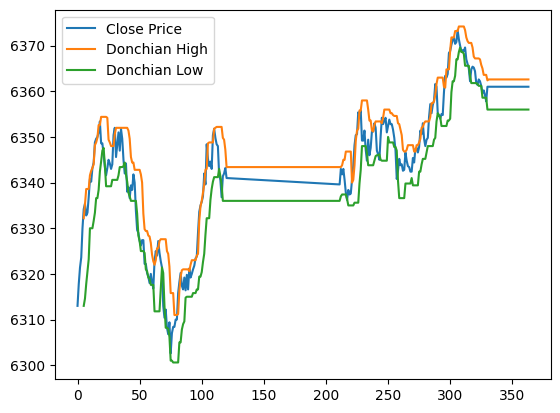

In [82]:
import matplotlib.pyplot as plt
plt.plot(result['close'], label='Close Price')
plt.plot(result['Donchian_High'], label='Donchian High')
plt.plot(result['Donchian_Low'], label='Donchian Low')
plt.legend()
plt.show()